# Lecture 6: Self-supervised learning and autoencoders


We provide a collab with training, inference, and clustering code using CNN-based autoencoders.

## Notebook steps:
1. Train an autoencoder on a single file
2. Train an autoencoder on a full file
3. Improve reconstruction quality with a perceptual loss
4. Perform clustering on the extracted features

In [23]:
# Install deps

# !pip install torch
# !pip install torchaudio
# !pip install torchcodec
# !pip install mirdata
# !pip install tqdm
# !pip install scikit-learn
# !pip install matplotlib
# !pip install umap-learn
# !pip install auraloss
# !pip install ipywidgets

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import mirdata
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import auraloss
import umap
from pathlib import Path
from typing import Tuple, Optional, List
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import DataLoader, Dataset, random_split
from torchaudio.transforms import MelSpectrogram, Resample
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from IPython.display import Audio, display
import ipywidgets as widgets


plt.rcParams["figure.figsize"] = (6,4)
torch.manual_seed(42)
np.random.seed(42)

# Set to cuda or cpu, depending on the runtime
#device = "cpu"
device = "cuda"

In [25]:
DATA_DIR = "/home/arjbah/Desktop/Coursework/ML/datasets/MTAT"
MP3_DIR = os.path.join(DATA_DIR, "mp3")
ANN_PATH = os.path.join(DATA_DIR, "annotations_final.csv")
CLIP_INFO_PATH = os.path.join(DATA_DIR, "clip_info_final.csv")
PREPROC_DIR = os.path.join(DATA_DIR, "preproc")

MODEL_DIR = "/home/arjbah/Desktop/Coursework/ML/Lab3"
LOGS_DIR = os.path.join(MODEL_DIR, "logs")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Base dir: {DATA_DIR}")
print(f"Using device: {device}")

Base dir: /home/arjbah/Desktop/Coursework/ML/datasets/MTAT
Using device: cuda


## Create Dataloader

In [26]:
# Dataloader for MTAT

"""
Modular MP3 DataLoader for MTAT Dataset

Key Features:
- Handles variable-length audio by padding/truncating to fixed duration
- Configurable sample rate and audio duration
- Memory-efficient: loads files on-demand
- Easy to extend with data augmentation
"""

class MTATDataset(Dataset):
    """
    PyTorch Dataset for loading MP3 files from MTAT with robust error handling
    
    Args:
        base_dir: Root directory containing subdirectories with MP3 files
        target_duration: Desired audio duration in seconds (default: 1.0)
        sample_rate: Target sample rate in Hz (default: 16000)
        mono: If True, convert stereo to mono (default: True)
    """
    
    def __init__(
        self,
        base_dir: str,
        target_duration: float = 1.0,
        sample_rate: int = 16000,
        mono: bool = True
    ):
        self.base_dir = Path(base_dir)
        self.target_duration = target_duration
        self.sample_rate = sample_rate
        self.mono = mono
        
        # Calculate target number of samples for consistent audio length
        self.target_samples = int(target_duration * sample_rate)
        
        # Collect all MP3 file paths from subdirectories
        self.file_paths = self._collect_files()
        
        # Track failed files
        self.failed_files = []
        
        if len(self.file_paths) == 0:
            raise ValueError(f"No MP3 files found in {base_dir}")
        
        print(f"Found {len(self.file_paths)} audio files")
        print(f"Target: {target_duration}s at {sample_rate}Hz = {self.target_samples} samples")
    
    def _collect_files(self) -> List[Path]:
        """
        Recursively collect all MP3 files from subdirectories.
        
        Returns:
            List of Path objects pointing to MP3 files
        """
        # Define expected subdirectory names: 0-9 and a-f
        subdirs = [str(i) for i in range(10)] + list('abcdef')
        
        file_paths = []
        for subdir in subdirs:
            subdir_path = self.base_dir / subdir
            if subdir_path.exists():
                # Collect all .mp3 files in this subdirectory
                mp3_files = list(subdir_path.glob('*.mp3'))
                file_paths.extend(mp3_files)
        
        return sorted(file_paths)  # Sort for reproducibility
    
    def _load_audio(self, file_path: Path) -> torch.Tensor:
        """
        Load and preprocess an audio file with error handling.
        
        Steps:
        1. Load audio with torchaudio
        2. Resample to target sample rate if needed
        3. Convert to mono if requested
        4. Pad or truncate to target duration
        
        Args:
            file_path: Path to the audio file
            
        Returns:
            Audio tensor of shape (1, target_samples) if mono, 
            or (2, target_samples) if stereo
            
        Raises:
            RuntimeError: If audio cannot be loaded
        """
        try:
            # Load audio file (returns waveform and original sample rate)
            waveform, orig_sr = torchaudio.load(file_path)
            
            # Resample if the original sample rate differs from target
            if orig_sr != self.sample_rate:
                resampler = torchaudio.transforms.Resample(orig_sr, self.sample_rate)
                waveform = resampler(waveform)
            
            # Convert stereo to mono by averaging channels
            if self.mono and waveform.shape[0] > 1:
                waveform = torch.mean(waveform, dim=0, keepdim=True)
            
            # Ensure consistent length: pad or truncate
            current_samples = waveform.shape[1]
            
            if current_samples < self.target_samples:
                # Pad with zeros if audio is too short
                padding = self.target_samples - current_samples
                waveform = torch.nn.functional.pad(waveform, (0, padding))
            elif current_samples > self.target_samples:
                # Truncate if audio is too long (take first target_samples)
                waveform = waveform[:, :self.target_samples]
            
            return waveform
            
        except Exception as e:
            raise RuntimeError(f"Failed to load {file_path.name}: {str(e)}")
    
    def __len__(self) -> int:
        """Return the total number of audio files in the dataset."""
        return len(self.file_paths)
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, str]:
        """
        Load and return a single audio sample with error handling.
        
        Args:
            idx: Index of the sample to load
            
        Returns:
            Tuple of (audio_tensor, filename)
            - audio_tensor: Preprocessed audio of shape (channels, target_samples)
                           or zeros tensor if loading failed
            - filename: Name of the audio file (for reference/debugging)
        """
        file_path = self.file_paths[idx]
        
        try:
            # Load and preprocess the audio
            audio = self._load_audio(file_path)
            return audio, file_path.name
            
        except Exception as e:
            # Log the failed file
            if file_path not in self.failed_files:
                self.failed_files.append(file_path)
                warnings.warn(f"Skipping corrupted file: {file_path.name} - {str(e)}")
            
            # Return a zero tensor of the correct shape as placeholder
            channels = 1 if self.mono else 2
            audio = torch.zeros(channels, self.target_samples)
            return audio, f"FAILED_{file_path.name}"


def create_dataloaders(
    base_dir: str,
    batch_size: int = 32,
    train_split: float = 0.8,
    shuffle: bool = True,
    num_workers: int = 4,
    target_duration: float = 1.0,
    sample_rate: int = 16000,
    seed: int = 42,
    **kwargs
) -> Tuple[DataLoader, DataLoader]:
    """
    Factory function to create train and validation PyTorch DataLoaders for MTAT.
    
    Args:
        base_dir: Root directory containing MP3 files
        batch_size: Number of samples per batch
        train_split: Fraction of data to use for training (default: 0.8)
        shuffle: Whether to shuffle training data each epoch
        num_workers: Number of subprocesses for data loading (use 0 for debugging)
        target_duration: Audio duration in seconds
        sample_rate: Target sample rate in Hz
        seed: Random seed for reproducible splits
        **kwargs: Additional arguments passed to DataLoader
        
    Returns:
        Tuple of (train_loader, val_loader)
    """
    
    # Create full dataset
    full_dataset = MTATDataset(
        base_dir=base_dir,
        target_duration=target_duration,
        sample_rate=sample_rate
    )
    
    # Calculate split sizes
    total_size = len(full_dataset)
    train_size = int(train_split * total_size)
    val_size = total_size - train_size
    
    print(f"\nDataset split:")
    print(f"  Training:   {train_size} samples ({train_split*100:.1f}%)")
    print(f"  Validation: {val_size} samples ({(1-train_split)*100:.1f}%)")
    
    # Split dataset
    generator = torch.Generator().manual_seed(seed)
    train_dataset, val_dataset = random_split(
        full_dataset, 
        [train_size, val_size],
        generator=generator
    )
    
    # Create train DataLoader
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        pin_memory=torch.cuda.is_available(),
        **kwargs
    )
    
    # Create validation DataLoader (no shuffle)
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,  # Don't shuffle validation data
        num_workers=num_workers,
        pin_memory=torch.cuda.is_available(),
        **kwargs
    )
    
    return train_loader, val_loader


# Helper function to check for corrupted files before training
def validate_dataset(base_dir: str, sample_rate: int = 16000, max_check: int = 100):
    """
    Check a sample of files to identify corrupted ones before training.
    
    Args:
        base_dir: Root directory containing MP3 files
        sample_rate: Target sample rate
        max_check: Maximum number of files to check
    """
    dataset = MTATDataset(base_dir=base_dir, target_duration=1.0, sample_rate=sample_rate)
    print(f"\nValidating up to {min(max_check, len(dataset))} files...")
    
    failed = []
    for i in range(min(max_check, len(dataset))):
        try:
            audio, filename = dataset[i]
            if filename.startswith("FAILED_"):
                failed.append(filename[7:])  # Remove "FAILED_" prefix
        except Exception as e:
            failed.append(f"{dataset.file_paths[i].name}: {str(e)}")
    
    if failed:
        print(f"\nFound {len(failed)} corrupted files:")
        for f in failed[:10]:  # Show first 10
            print(f"  - {f}")
        if len(failed) > 10:
            print(f"  ... and {len(failed) - 10} more")
    else:
        print("All checked files are valid!")
    
    return failed

### Test dataloader

In [27]:
# # Example usage and testing

# # Configuration
# DATA_DIR = "/home/arjbah/Desktop/Coursework/ML/datasets/MTAT/mp3"
# BATCH_SIZE = 1
# SAMPLE_RATE = 16000
# DURATION = 1

# # Create DataLoader
# train_loader = create_dataloaders(
#     base_dir=DATA_DIR,
#     batch_size=BATCH_SIZE,
#     shuffle=True,
#     num_workers=2,
#     target_duration=DURATION,
#     sample_rate=SAMPLE_RATE
# )

# # Test the DataLoader
# print(f"\nDataLoader created successfully!")
# print(f"Number of batches: {len(train_loader)}")

# # Load and inspect first batch
# audio_batch, filenames = next(iter(train_loader))
# print(f"\nBatch shape: {audio_batch.shape}")
# print(f"Expected: ({BATCH_SIZE}, 1, {int(DURATION * SAMPLE_RATE)})")
# print(f"\nFirst few filenames: {filenames[:3]}")

# 1. Training on a single audio

In [28]:
class AutoencConv1D(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder filterbank. Using stride for downsampling, padding (kernel_size/2-1) to center filter at 0.
        self.enc_conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=2048, stride=1024, padding=1023, bias=True)

        # Decoder filterbank
        self.dec_convt1 = nn.ConvTranspose1d(in_channels=32, out_channels=1, kernel_size=2048, stride=1024, padding=1023, bias=True)

    def encoder(self, x):
        x = self.enc_conv1(x)
        x = torch.tanh(x)
        return x

    def decoder(self, x):
        x = self.dec_convt1(x)
        return x

    def forward(self, x):
        z = self.encoder(x)

        x_reconstructed = self.decoder(z)
        return x_reconstructed

In [29]:
# audio_batch, filenames = next(iter(train_loader))
# waveform = audio_batch[0]

# print(f"{filenames[0]} sound with shape: {waveform.shape}")

In [30]:
# from IPython.display import Audio
# samplerate = 16000
# Audio(waveform.cpu().numpy(), rate=samplerate)

In [31]:
# model = AutoencConv1D().to(device)
# waveform = waveform.to(device)
# num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# print(f"AutoencConv1D parameters: {num_params}")

In [32]:
# # Do a forward pass to measure output length
# waveform_reconstructed = model(waveform)
# len_output = waveform_reconstructed.shape[1]

# # Trim target reference to this duration
# waveform_target = waveform[:,:len_output]
# waveform_target.shape

In [33]:
# waveform_target

In [34]:
# # Training loop
# n_epochs = 100
# #loss_function = nn.MSELoss()
# #loss_function = auraloss.time.SNRLoss()
# #loss_function = auraloss.time.SISDRLoss()
# #loss_function = auraloss.time.SDSDRLoss()
# loss_function = auraloss.time.ESRLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


# pbar = trange(n_epochs, desc="Training", unit="epoch")
# for epoch in pbar:
#     waveform_predicted = model(waveform)
#     loss = loss_function(waveform_predicted, waveform_target)
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

#     pbar.set_postfix({"loss": f"{loss.item():.7f}"})

In [35]:
# waveform_reconstructed = model(waveform).detach().cpu()
# Audio(waveform_reconstructed.numpy(), rate=samplerate)

In [36]:
# print("Input:", waveform.shape)
# bottleneck = model.encoder(waveform)
# print("Bottleneck:", bottleneck.shape)
# output = model.decoder(bottleneck)
# print("Output:", output.shape)

In [37]:
# # Try on another audio
# audio_batch2, filename2 = next(iter(train_loader))
# waveform2 = audio_batch2[0]

# print(f"{filename2[0]} sound with shape: {waveform2.shape}")

In [38]:
# Audio(waveform2.cpu().numpy(), rate=samplerate)

In [39]:
# waveform2 = waveform2.to(device)
# waveform2_reconstructed = model(waveform2).detach().cpu()
# Audio(waveform2_reconstructed.cpu().numpy(), rate=samplerate)

# 2. Trained on a dataset

In [40]:
import torch
import torch.nn as nn

class AudioAutoencoder(nn.Module):
    """A more capable audio autoencoder featuring batch-norm, PReLu activations,
    and shared indices for the downsampling and upsampling layers.
    """
    def __init__(
        self,
        input_length=16000,
        bottleneck_size=64,
        kernel_size=5,
        channels=8,
        channel_mult=2,
        downsample=4,
    ):
        super().__init__()
        assert kernel_size % 2 == 1, "kernel_size should be odd for same padding"

        padding = kernel_size // 2

        # ----- Encoder -----
        self.enc_conv1 = nn.Conv1d(1, channels, kernel_size=kernel_size, padding=padding)
        self.enc_norm1 = nn.BatchNorm1d(channels)
        self.enc_act1 = nn.PReLU()
        self.pool1 = nn.MaxPool1d(2, stride=downsample, return_indices=True)

        self.enc_conv2 = nn.Conv1d(channels, channels * channel_mult, kernel_size=kernel_size, padding=padding)
        self.enc_norm2 = nn.BatchNorm1d(channels * channel_mult)
        self.enc_act2 = nn.PReLU()
        self.pool2 = nn.MaxPool1d(2, stride=downsample, return_indices=True)

        self.enc_conv3 = nn.Conv1d(channels * channel_mult, channels * channel_mult ** 2, kernel_size=kernel_size, padding=padding)
        self.enc_norm3 = nn.BatchNorm1d(channels * channel_mult ** 2)
        self.enc_act3 = nn.PReLU()
        self.pool3 = nn.MaxPool1d(2, stride=downsample, return_indices=True)

        enc_out_len = input_length // downsample ** 3 * channels * channel_mult ** 2  # 3× pooling halves length thrice
        self.enc_fc = nn.Linear(enc_out_len, bottleneck_size)

        comp_rate =  input_length / bottleneck_size
        print(f"Compression rate: {comp_rate:.1f}X")

        # ----- Decoder -----
        self.dec_fc = nn.Linear(bottleneck_size, enc_out_len)

        self.unpool3 = nn.MaxUnpool1d(2, stride=downsample)
        self.dec_deconv3 = nn.Conv1d(channels * channel_mult ** 2, channels * channel_mult, kernel_size=kernel_size, padding=padding)
        self.dec_act3 = nn.PReLU()

        self.unpool2 = nn.MaxUnpool1d(2, stride=downsample)
        self.dec_deconv2 = nn.Conv1d(channels * channel_mult, channels, kernel_size=kernel_size, padding=padding)
        self.dec_act2 = nn.PReLU()

        self.unpool1 = nn.MaxUnpool1d(2, stride=downsample)
        self.dec_deconv1 = nn.Conv1d(channels, 1, kernel_size=kernel_size, padding=padding)
        self.dec_tanh = nn.Tanh()

    def encoder(self, x):
        sizes, indices = [], []

        x = self.enc_act1(self.enc_norm1(self.enc_conv1(x)))
        sizes.append(x.size())
        x, idx1 = self.pool1(x)
        indices.append(idx1)

        x = self.enc_act2(self.enc_norm2(self.enc_conv2(x)))
        sizes.append(x.size())
        x, idx2 = self.pool2(x)
        indices.append(idx2)

        x = self.enc_act3(self.enc_norm3(self.enc_conv3(x)))
        sizes.append(x.size())
        x, idx3 = self.pool3(x)
        indices.append(idx3)
        x = x.flatten(start_dim=1)

        x = self.enc_fc(x)
        return x, indices, sizes

    # ----- Decoder -----
    def decoder(self, z, indices, sizes):
        idx1, idx2, idx3 = indices
        size1, size2, size3 = sizes

        x = self.dec_fc(z)
        x = x.view(size3[0], size3[1], -1)

        x = self.unpool3(x, idx3, output_size=size3)
        x = self.dec_act3(self.dec_deconv3(x))

        x = self.unpool2(x, idx2, output_size=size2)
        x = self.dec_act2(self.dec_deconv2(x))

        x = self.unpool1(x, idx1, output_size=size1)
        x = self.dec_tanh(self.dec_deconv1(x))

        return x

    # ----- Forward -----
    def forward(self, x):
        z, indices, sizes = self.encoder(x)
        x_r = self.decoder(z, indices, sizes)
        return x_r, z

In [44]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Dataloader setup
target_length = 16000  # 1 second at 16kHz
batch_size = 32  # change for efficiency

train_loader, val_loader = create_dataloaders(
    base_dir=MP3_DIR,
    batch_size=batch_size,  # Changed from 1
    train_split=0.8,
    shuffle=True,
    num_workers=8,
    target_duration=1.0,
    sample_rate=16000,
    seed=42
)

# Model setup
bottleneck_size = 512
downsample = 2

model = AudioAutoencoder(
    input_length=target_length, 
    bottleneck_size=bottleneck_size, 
    downsample=downsample
)
model.to(device)

# Training setup
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 20  # change

# Track best validation loss
best_val_loss = float('inf')

# Training loop
pbar = trange(num_epochs, desc="Training", unit="epoch")
for epoch in pbar:
    # ========== TRAINING ==========
    model.train()
    loss_train = []
    train_valid_batches = 0
    
    for i, (x, filenames) in enumerate(train_loader):
        # Skip batches with failed files
        if any(f.startswith("FAILED_") for f in filenames):
            continue
            
        x = x.to(device)
        
        optimizer.zero_grad()
        x_reconstr, _ = model(x)
        loss = criterion(x_reconstr, x)
        loss.backward()
        optimizer.step()
        
        loss_train.append(loss.item())
        train_valid_batches += 1
    
    # ========== VALIDATION ==========
    model.eval()
    loss_val = []
    val_valid_batches = 0
    
    with torch.no_grad():
        for i, (x, filenames) in enumerate(val_loader):
            if any(f.startswith("FAILED_") for f in filenames):
                continue
                
            x = x.to(device)
            
            x_reconstr, _ = model(x)
            loss = criterion(x_reconstr, x)
            
            loss_val.append(loss.item())
            val_valid_batches += 1
    
    # ========== LOGGING ==========
    if loss_train and loss_val:
        avg_train_loss = np.mean(loss_train)
        avg_val_loss = np.mean(loss_val)
        
        pbar.set_postfix({
            "epoch": epoch + 1,
            "train_loss": f"{avg_train_loss:.5f}",
            "val_loss": f"{avg_val_loss:.5f}",
        })
        
        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
            }, 'best_model.pt')
            print(f"\n✅ Saved best model (val_loss: {avg_val_loss:.5f})")
    else:
        print(f"Epoch {epoch + 1}: No valid batches!")

print("\n" + "="*50)
print("Training complete!")
print(f"Best validation loss: {best_val_loss:.5f}")
print("="*50)

# Check for failed files
if hasattr(train_loader.dataset.dataset, 'failed_files'):
    failed = train_loader.dataset.dataset.failed_files
    if failed:
        print(f"\n⚠️  {len(failed)} files failed to load:")
        for f in failed[:5]:
            print(f"  - {f.name}")
        if len(failed) > 5:
            print(f"  ... and {len(failed) - 5} more")

Using device: cuda
Found 25860 audio files
Target: 1.0s at 16000Hz = 16000 samples

Dataset split:
  Training:   20688 samples (80.0%)
  Validation: 5172 samples (20.0%)
Compression rate: 31.2X


Training:   5%| | 1/20 [01:43<32:54, 103.92s/epoch, epoch=1, train_loss=0.00995,


✅ Saved best model (val_loss: 0.00431)


Training:  10%| | 2/20 [02:39<22:40, 75.56s/epoch, epoch=2, train_loss=0.00384, 


✅ Saved best model (val_loss: 0.00306)


Training:  15%|▏| 3/20 [03:34<18:41, 65.96s/epoch, epoch=3, train_loss=0.00301, 


✅ Saved best model (val_loss: 0.00271)


Training:  30%|▎| 6/20 [05:36<10:46, 46.20s/epoch, epoch=6, train_loss=0.00223, 


✅ Saved best model (val_loss: 0.00205)


Training:  40%|▍| 8/20 [06:55<08:30, 42.58s/epoch, epoch=8, train_loss=0.00205, 


✅ Saved best model (val_loss: 0.00196)


Training:  65%|▋| 13/20 [09:57<04:23, 37.59s/epoch, epoch=13, train_loss=0.00177


✅ Saved best model (val_loss: 0.00180)


Training:  80%|▊| 16/20 [11:43<02:24, 36.10s/epoch, epoch=16, train_loss=0.00162


✅ Saved best model (val_loss: 0.00180)


Training:  95%|▉| 19/20 [13:28<00:35, 35.56s/epoch, epoch=19, train_loss=0.00151


✅ Saved best model (val_loss: 0.00174)


Training: 100%|█| 20/20 [14:03<00:00, 42.16s/epoch, epoch=20, train_loss=0.00148


Training complete!
Best validation loss: 0.00174


In [47]:
# Get a batch from validation loader for listening
batch = next(iter(val_loader))
x, filenames = batch  # Unpack tuple: (audio_tensors, filenames)

# Move to device and get reconstruction
x = x.to(device)
x_r, _ = model(x)

# Move back to CPU for playback
x = x.detach().cpu()
x_r = x_r.detach().cpu()

In [49]:
# Listen to original vs reconstructed audio
# Select an audio sample from the batch
sample_idx = 0  # change to try different samples (0 to batch_size-1)

print(f"Playing sample: {filenames[sample_idx]}")
print("="*50)

# Original audio
print("Original Audio:")
display(Audio(x[sample_idx].squeeze().numpy(), rate=16000))

# Reconstructed audio
print("Reconstructed Audio:")
display(Audio(x_r[sample_idx].squeeze().numpy(), rate=16000))

# Optional: Show reconstruction quality metrics
mse = torch.mean((x[sample_idx] - x_r[sample_idx])**2).item()
print(f"\nMSE: {mse:.6f}")

Playing sample: paul_avgerinos-balancing_spheres-05-day_dreams__and_thirst_is_quenched-1074-1103.mp3
Original Audio:


Reconstructed Audio:



MSE: 0.000174


# 3. Improve reconstruction with a perceptual loss

In [ ]:
def multi_scale_stft_loss(x, y, scales=[512, 1024, 2048], hop_ratio=0.25):
    """Multi-scale STFT loss with proper normalization."""
    loss = 0
    for n_fft in scales:
        hop = int(n_fft * hop_ratio)
        window = torch.hann_window(n_fft, device=x.device)
        X = torch.stft(x.squeeze(1), n_fft=n_fft, hop_length=hop, window=window, return_complex=True)
        Y = torch.stft(y.squeeze(1), n_fft=n_fft, hop_length=hop, window=window, return_complex=True)
        
        # Spectral convergence loss (normalized)
        sc_loss = torch.norm(X.abs() - Y.abs(), p='fro') / torch.norm(X.abs(), p='fro')
        
        # Log magnitude loss (normalized)
        log_loss = torch.mean(torch.abs(torch.log(X.abs() + 1e-8) - torch.log(Y.abs() + 1e-8)))
        
        loss += sc_loss + log_loss
    
    return loss / len(scales)

# Time-domain loss function
esr_loss = auraloss.time.ESRLoss()

Compression rate: 31.2X


Training:   0%|             | 0/20 [00:32<?, ?epoch/s, trn=271.5563, val=0.5659]


Epoch 1/20
  Train - Total: 271.5563 | STFT: 0.5596 | ESR: 270.996708
  Val   - Total: 0.5659 | STFT: 0.4018 | ESR: 0.164100


Training:   5%|▎    | 1/20 [00:33<10:27, 33.02s/epoch, trn=271.5563, val=0.5659]

  ✅ Saved best model!


Training:   5%|▎      | 1/20 [01:05<10:27, 33.02s/epoch, trn=1.3412, val=0.4756]


Epoch 2/20
  Train - Total: 1.3412 | STFT: 0.3823 | ESR: 0.958881
  Val   - Total: 0.4756 | STFT: 0.3541 | ESR: 0.121555


Training:  10%|▋      | 2/20 [01:05<09:53, 32.97s/epoch, trn=1.3412, val=0.4756]

  ✅ Saved best model!


Training:  10%|▋      | 2/20 [01:38<09:53, 32.97s/epoch, trn=0.6520, val=0.3427]


Epoch 3/20
  Train - Total: 0.6520 | STFT: 0.3550 | ESR: 0.296953
  Val   - Total: 0.3427 | STFT: 0.3304 | ESR: 0.012384


Training:  15%|█      | 3/20 [01:38<09:20, 32.99s/epoch, trn=0.6520, val=0.3427]

  ✅ Saved best model!


Training:  20%|█▍     | 4/20 [02:10<08:41, 32.60s/epoch, trn=0.8403, val=0.8182]


Epoch 4/20
  Train - Total: 0.8403 | STFT: 0.3372 | ESR: 0.503158
  Val   - Total: 0.8182 | STFT: 0.4022 | ESR: 0.415994


Training:  25%|█▊     | 5/20 [02:43<08:07, 32.47s/epoch, trn=0.5587, val=0.3838]


Epoch 5/20
  Train - Total: 0.5587 | STFT: 0.3155 | ESR: 0.243149
  Val   - Total: 0.3838 | STFT: 0.2937 | ESR: 0.090160


Training:  30%|██     | 6/20 [03:15<07:33, 32.37s/epoch, trn=1.1495, val=0.6325]


Epoch 6/20
  Train - Total: 1.1495 | STFT: 0.3019 | ESR: 0.847561
  Val   - Total: 0.6325 | STFT: 0.2826 | ESR: 0.349838


Training:  35%|██▍    | 7/20 [03:47<06:59, 32.25s/epoch, trn=0.7064, val=0.4951]


Epoch 7/20
  Train - Total: 0.7064 | STFT: 0.2941 | ESR: 0.412272
  Val   - Total: 0.4951 | STFT: 0.2791 | ESR: 0.216070


Training:  40%|██▊    | 8/20 [04:19<06:26, 32.21s/epoch, trn=8.8821, val=1.7554]


Epoch 8/20
  Train - Total: 8.8821 | STFT: 0.2906 | ESR: 8.591536
  Val   - Total: 1.7554 | STFT: 0.2783 | ESR: 1.477071


Training:  45%|███▏   | 9/20 [04:51<05:53, 32.15s/epoch, trn=1.5518, val=4.0848]


Epoch 9/20
  Train - Total: 1.5518 | STFT: 0.2858 | ESR: 1.266036
  Val   - Total: 4.0848 | STFT: 0.2813 | ESR: 3.803476


Training:  45%|███▏   | 9/20 [05:23<05:53, 32.15s/epoch, trn=1.0352, val=0.3189]


Epoch 10/20
  Train - Total: 1.0352 | STFT: 0.2772 | ESR: 0.758023
  Val   - Total: 0.3189 | STFT: 0.2617 | ESR: 0.057223


Training:  50%|███   | 10/20 [05:24<05:23, 32.39s/epoch, trn=1.0352, val=0.3189]

  ✅ Saved best model!


Training:  55%|███▎  | 11/20 [05:57<04:52, 32.46s/epoch, trn=3.9995, val=0.7004]


Epoch 11/20
  Train - Total: 3.9995 | STFT: 0.2768 | ESR: 3.722695
  Val   - Total: 0.7004 | STFT: 0.2850 | ESR: 0.415439


Training:  60%|███▌  | 12/20 [06:29<04:20, 32.52s/epoch, trn=0.4547, val=0.4185]


Epoch 12/20
  Train - Total: 0.4547 | STFT: 0.2675 | ESR: 0.187216
  Val   - Total: 0.4185 | STFT: 0.2634 | ESR: 0.155074


Training:  65%|███▉  | 13/20 [07:01<03:47, 32.44s/epoch, trn=1.1701, val=0.5489]


Epoch 13/20
  Train - Total: 1.1701 | STFT: 0.2755 | ESR: 0.894587
  Val   - Total: 0.5489 | STFT: 0.2690 | ESR: 0.279873


Training:  70%|████▏ | 14/20 [07:34<03:13, 32.32s/epoch, trn=0.5683, val=0.5801]


Epoch 14/20
  Train - Total: 0.5683 | STFT: 0.2657 | ESR: 0.302581
  Val   - Total: 0.5801 | STFT: 0.2547 | ESR: 0.325455


Training:  70%|████▏ | 14/20 [08:06<03:13, 32.32s/epoch, trn=0.5265, val=0.2683]


Epoch 15/20
  Train - Total: 0.5265 | STFT: 0.2613 | ESR: 0.265220
  Val   - Total: 0.2683 | STFT: 0.2526 | ESR: 0.015695


Training:  75%|████▌ | 15/20 [08:07<02:42, 32.53s/epoch, trn=0.5265, val=0.2683]

  ✅ Saved best model!


Training:  80%|████▊ | 16/20 [08:38<02:09, 32.35s/epoch, trn=0.6428, val=0.5084]


Epoch 16/20
  Train - Total: 0.6428 | STFT: 0.2602 | ESR: 0.382583
  Val   - Total: 0.5084 | STFT: 0.2495 | ESR: 0.258835


Training:  85%|█████ | 17/20 [09:10<01:36, 32.21s/epoch, trn=0.6149, val=0.3688]


Epoch 17/20
  Train - Total: 0.6149 | STFT: 0.2621 | ESR: 0.352857
  Val   - Total: 0.3688 | STFT: 0.2514 | ESR: 0.117415


Training:  90%|█████▍| 18/20 [09:42<01:04, 32.17s/epoch, trn=0.8343, val=0.3728]


Epoch 18/20
  Train - Total: 0.8343 | STFT: 0.2584 | ESR: 0.575937
  Val   - Total: 0.3728 | STFT: 0.2606 | ESR: 0.112149


Training:  95%|█████▋| 19/20 [10:15<00:32, 32.15s/epoch, trn=0.7569, val=2.4740]


Epoch 19/20
  Train - Total: 0.7569 | STFT: 0.2589 | ESR: 0.498000
  Val   - Total: 2.4740 | STFT: 0.2527 | ESR: 2.221318


Training: 100%|██████| 20/20 [10:47<00:00, 32.35s/epoch, trn=0.4770, val=0.2824]



Epoch 20/20
  Train - Total: 0.4770 | STFT: 0.2539 | ESR: 0.223087
  Val   - Total: 0.2824 | STFT: 0.2564 | ESR: 0.026011

Training complete!
Best validation loss: 0.2683


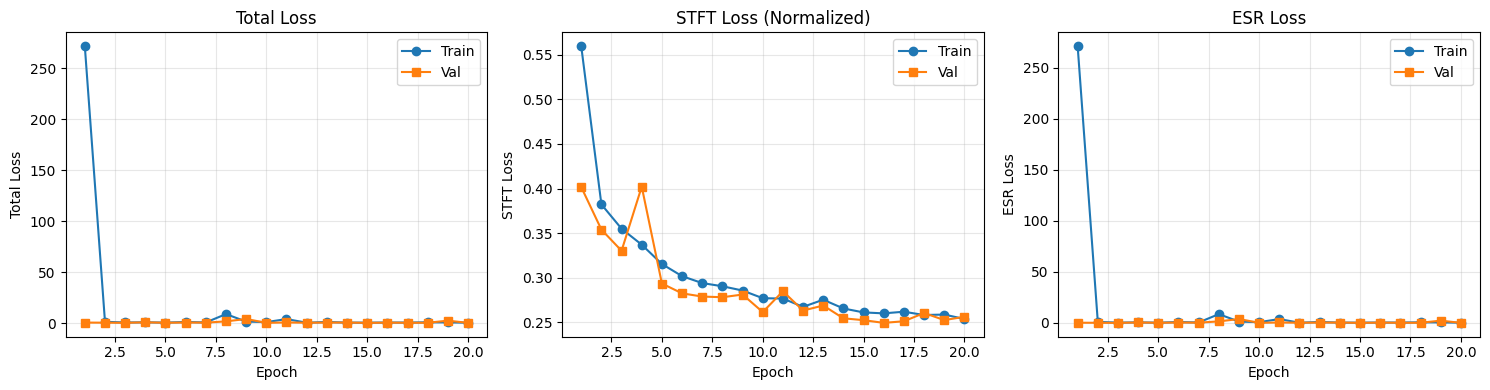

In [65]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model setup
target_length = 16000
bottleneck_size = 512
downsample = 2

model = AudioAutoencoder(
    input_length=target_length, 
    bottleneck_size=bottleneck_size, 
    downsample=downsample
)
model.to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training setup
num_epochs = 20
best_val_loss = float('inf')
train_history = []
val_history = []

# Training loop
pbar = trange(num_epochs, desc="Training", unit="epoch")
for epoch in pbar:
    # ========== TRAINING ==========
    model.train()
    loss_train_total = []
    loss_train_stft = []
    loss_train_esr = []
    
    for i, (x, filenames) in enumerate(train_loader):
        if any(f.startswith("FAILED_") for f in filenames):
            continue
        
        x = x.to(device)
        
        optimizer.zero_grad()
        x_reconstr, _ = model(x)
        
        # Calculate normalized losses
        l_stft = multi_scale_stft_loss(x, x_reconstr)
        l_esr = esr_loss(x_reconstr, x)/10000
        
        # Simple addition - both are on similar scales (approx 0-1 range)
        loss = l_stft + l_esr
        
        if torch.isnan(loss) or torch.isinf(loss):
            print(f"Warning: Invalid loss at batch {i}, skipping...")
            continue
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        loss_train_total.append(loss.item())
        loss_train_stft.append(l_stft.item())
        loss_train_esr.append(l_esr.item())
    
    avg_train_total = np.mean(loss_train_total) if loss_train_total else float('inf')
    avg_train_stft = np.mean(loss_train_stft) if loss_train_stft else float('inf')
    avg_train_esr = np.mean(loss_train_esr) if loss_train_esr else float('inf')
    
    # ========== VALIDATION ==========
    model.eval()
    loss_val_total = []
    loss_val_stft = []
    loss_val_esr = []
    
    with torch.no_grad():
        for i, (x, filenames) in enumerate(val_loader):
            if any(f.startswith("FAILED_") for f in filenames):
                continue
            
            x = x.to(device)
            x_reconstr, _ = model(x)
            
            l_stft = multi_scale_stft_loss(x, x_reconstr)
            l_esr = esr_loss(x_reconstr, x)/10000
            loss = l_stft + l_esr
            
            if torch.isnan(loss) or torch.isinf(loss):
                continue
            
            loss_val_total.append(loss.item())
            loss_val_stft.append(l_stft.item())
            loss_val_esr.append(l_esr.item())
    
    avg_val_total = np.mean(loss_val_total) if loss_val_total else float('inf')
    avg_val_stft = np.mean(loss_val_stft) if loss_val_stft else float('inf')
    avg_val_esr = np.mean(loss_val_esr) if loss_val_esr else float('inf')
    
    # Store history
    train_history.append({
        'total': avg_train_total,
        'stft': avg_train_stft,
        'esr': avg_train_esr
    })
    val_history.append({
        'total': avg_val_total,
        'stft': avg_val_stft,
        'esr': avg_val_esr
    })
    
    # Progress bar
    pbar.set_postfix({
        "trn": f"{avg_train_total:.4f}",
        "val": f"{avg_val_total:.4f}"
    })
    
    # Detailed logging
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print(f"  Train - Total: {avg_train_total:.4f} | STFT: {avg_train_stft:.4f} | ESR: {avg_train_esr:.6f}")
    print(f"  Val   - Total: {avg_val_total:.4f} | STFT: {avg_val_stft:.4f} | ESR: {avg_val_esr:.6f}")
    
    # Save best model
    if avg_val_total < best_val_loss:
        best_val_loss = avg_val_total
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_history': train_history,
            'val_history': val_history,
        }, 'best_model_stft.pt')
        print(f"  ✅ Saved best model!")

print("\n" + "="*50)
print("Training complete!")
print(f"Best validation loss: {best_val_loss:.4f}")
print("="*50)

# Plot loss curves
import matplotlib.pyplot as plt

epochs = range(1, len(train_history) + 1)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Total loss
axes[0].plot(epochs, [h['total'] for h in train_history], label='Train', marker='o')
axes[0].plot(epochs, [h['total'] for h in val_history], label='Val', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Total Loss')
axes[0].set_title('Total Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# STFT loss
axes[1].plot(epochs, [h['stft'] for h in train_history], label='Train', marker='o')
axes[1].plot(epochs, [h['stft'] for h in val_history], label='Val', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('STFT Loss')
axes[1].set_title('STFT Loss (Normalized)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# ESR loss
axes[2].plot(epochs, [h['esr'] for h in train_history], label='Train', marker='o')
axes[2].plot(epochs, [h['esr'] for h in val_history], label='Val', marker='s')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('ESR Loss')
axes[2].set_title('ESR Loss')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [66]:
# Get a batch from validation loader for listening
batch = next(iter(val_loader))
x, filenames = batch  # Unpack tuple: (audio_tensors, filenames)

# Move to device and get reconstruction
x = x.to(device)
x_r, _ = model(x)

# Move back to CPU for playback
x = x.detach().cpu()
x_r = x_r.detach().cpu()

In [67]:
# Listen to original vs reconstructed audio
# Select an audio sample from the batch
sample_idx = 0  # change to try different samples (0 to batch_size-1)

print(f"Playing sample: {filenames[sample_idx]}")
print("="*50)

# Original audio
print("Original Audio:")
display(Audio(x[sample_idx].squeeze().numpy(), rate=16000))

print("\n")

# Reconstructed audio
print("Reconstructed Audio:")
display(Audio(x_r[sample_idx].squeeze().numpy(), rate=16000))

# Optional: Show reconstruction quality metrics
mse = torch.mean((x[sample_idx] - x_r[sample_idx])**2).item()
print(f"\nMSE: {mse:.6f}")

Playing sample: paul_avgerinos-balancing_spheres-05-day_dreams__and_thirst_is_quenched-1074-1103.mp3
Original Audio:




Reconstructed Audio:



MSE: 0.000167


# 4. Plot a 2D projection of the val set features with uMap

How is the separation of the latent space?

Extracting embeddings: 100%|██████████████████| 162/162 [00:04<00:00, 33.34it/s]
/home/arjbah/Desktop/Coursework/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Extracted 5172 embeddings of shape (5172, 512)
Found 230 unique labels
Label distribution: (array(['aba_structure', 'altri_stromenti', 'ambient_teknology',
       'american_bach_soloists', 'american_baroque', 'ammonite', 'anamar',
       'antiguru', 'anup', 'apa_ya', 'artemis', 'arthur_yoria', 'asteria',
       'atomic_opera', 'barbara_leoni', 'barry_phillips',
       'beatundercontrol', 'beight', 'belief_systems', 'beth_quist',
       'bjorn_fogelberg', 'brad_sucks', 'briddes_roune',
       'burning_babylon', 'burnshee_thornside', 'c__layne', 'c_layne',
       'cargo_cult', 'cheryl_ann_fulton', 'chris_harvey',
       'chris_juergensen', 'claire_fitch', 'curandero', 'curl',
       'da_camera', 'dac_crowell', 'daniel_ben_pienaar', 'daniel_berkman',
       'dj_cary', 'dj_markitos', 'doc_rossi', 'domased', 'dr_kuch',
       'drevo', 'drop_trio', 'duo_chambure', 'ed_martin', 'edward_martin',
       'edward_martin_and_paul_berget',
       'edward_martin_and_william_bastian', 'ehren_starks',

/tmp/ipykernel_98890/605141696.py:99: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  markerfacecolor=plt.cm.get_cmap(cmap)(idx/n_labels),


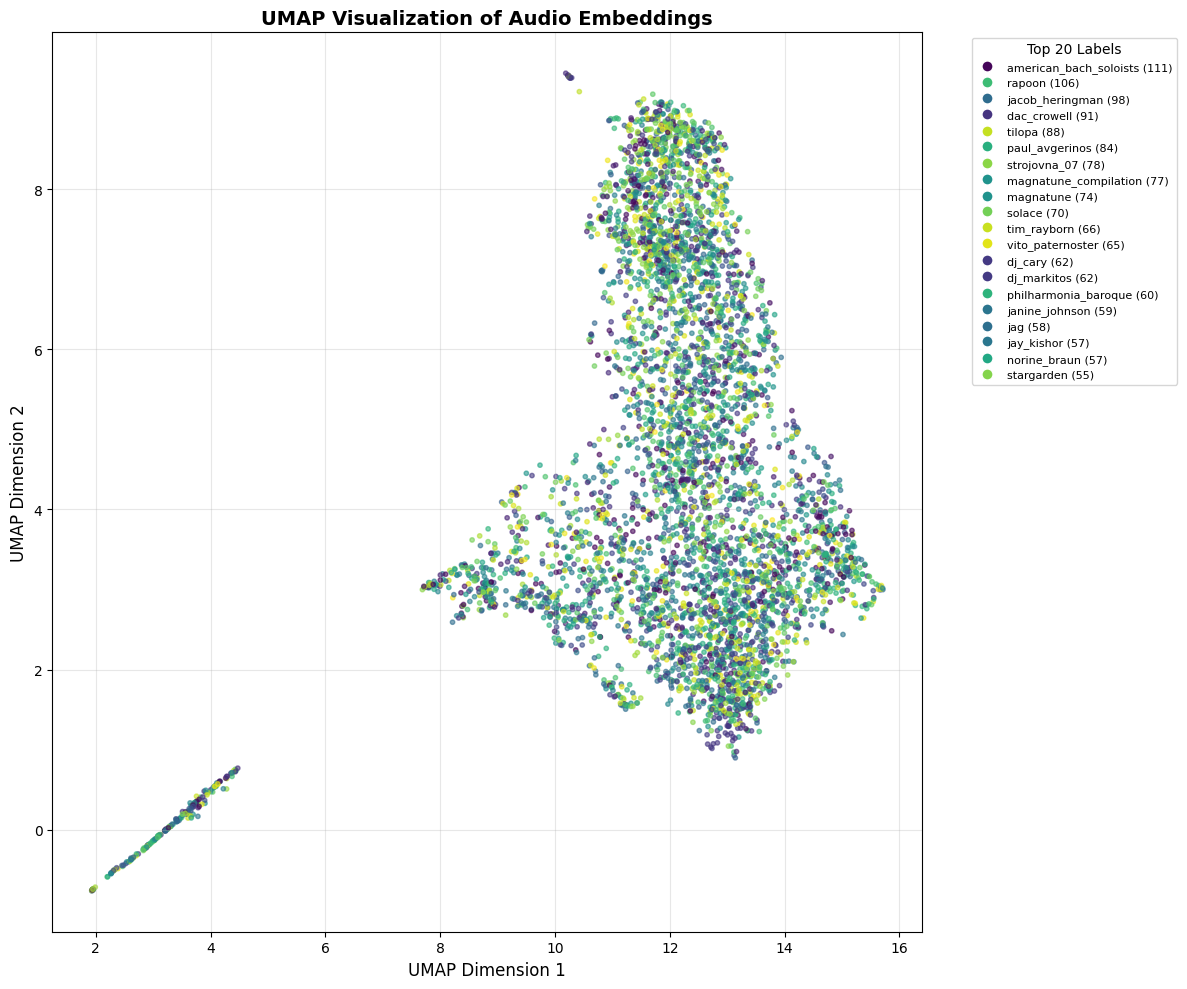


Embedding space statistics:
  Embedding dimension: 512
  Number of samples: 5172
  Embedding mean: -0.4393
  Embedding std: 28.7611


In [70]:
# Extract embeddings for the validation set
model.eval()
embeddings = []
filenames_list = []

with torch.no_grad():
    for x, filenames in tqdm(val_loader, desc="Extracting embeddings"):
        x = x.to(device)  # Already shape (batch, 1, 16000)
        _, z = model(x)
        embeddings.append(z.cpu().numpy())
        filenames_list.extend(filenames)

embeddings = np.concatenate(embeddings, axis=0)

print(f"Extracted {len(embeddings)} embeddings of shape {embeddings.shape}")

# Extract labels from filenames (assuming filename format contains genre/artist info)
# Example: "rock-song-name.mp3" or "artist-album-track.mp3"
# Adjust this parsing based on your actual filename format
def extract_label_from_filename(filename):
    """
    Extract a label from the filename. Customize based on your dataset structure.
    Examples:
    - "rock-song.mp3" -> "rock"
    - "artist-album-01.mp3" -> "artist"
    """
    # Skip failed files
    if filename.startswith("FAILED_"):
        return "unknown"
    
    # Remove .mp3 extension
    name = filename.replace('.mp3', '')
    
    # Try to extract first part before dash or underscore
    if '-' in name:
        return name.split('-')[0]
    elif '_' in name:
        return name.split('_')[0]
    else:
        # If no separator, use first few characters as label
        return name[:10] if len(name) > 10 else name

# Extract labels from filenames
labels = [extract_label_from_filename(f) for f in filenames_list]
labels = np.array(labels)

print(f"Found {len(np.unique(labels))} unique labels")
print(f"Label distribution: {np.unique(labels, return_counts=True)}")

# Perform UMAP
print("Running UMAP dimensionality reduction...")
reducer = umap.UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    metric='cosine',
    random_state=42
)
umap_embeddings = reducer.fit_transform(embeddings)

# Create UMAP plot
plt.figure(figsize=(12, 10))

unique_labels = np.unique(labels)
n_labels = len(unique_labels)

# Use different colormaps based on number of labels
if n_labels <= 10:
    cmap = 'tab10'
elif n_labels <= 20:
    cmap = 'tab20'
else:
    cmap = 'viridis'

# Map labels to indices
label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
label_indices = np.array([label_to_idx[label] for label in labels])

# Create scatter plot
scatter = plt.scatter(
    umap_embeddings[:, 0], 
    umap_embeddings[:, 1],
    c=label_indices, 
    cmap=cmap, 
    s=10,
    alpha=0.6
)

# Add legend
if n_labels > 20:
    # Show only top 20 most frequent labels
    label_counts = {label: np.sum(labels == label) for label in unique_labels}
    top_labels = sorted(label_counts.keys(), key=lambda x: label_counts[x], reverse=True)[:20]
    
    handles = []
    for label in top_labels:
        idx = label_to_idx[label]
        handle = plt.Line2D([0], [0], marker='o', color='w', 
                          markerfacecolor=plt.cm.get_cmap(cmap)(idx/n_labels), 
                          markersize=8, label=f"{label} ({label_counts[label]})")
        handles.append(handle)
    
    plt.legend(handles=handles, title="Top 20 Labels", 
              bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
else:
    # Show all labels
    handles, _ = scatter.legend_elements(num=n_labels)
    label_counts = {label: np.sum(labels == label) for label in unique_labels}
    legend_labels = [f"{label} ({label_counts[label]})" for label in unique_labels]
    plt.legend(handles, legend_labels, title="Labels",
              bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)

plt.title('UMAP Visualization of Audio Embeddings', fontsize=14, fontweight='bold')
plt.xlabel('UMAP Dimension 1', fontsize=12)
plt.ylabel('UMAP Dimension 2', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Optional: Print some statistics
print(f"\nEmbedding space statistics:")
print(f"  Embedding dimension: {embeddings.shape[1]}")
print(f"  Number of samples: {embeddings.shape[0]}")
print(f"  Embedding mean: {embeddings.mean():.4f}")
print(f"  Embedding std: {embeddings.std():.4f}")

# Audio Autoencoder Training Report: Perceptual Loss Optimization on MagnaTagATune

## 1. Dataset and Data Loading

### Dataset Overview
The MagnaTagATune (MTAT) dataset is a widely-used benchmark for Music Information Retrieval (MIR) research, containing 25,863 audio clips sourced from 230 artists on magnatune.com. Each clip is 29 seconds long, encoded as mono MP3 at 16 kHz sample rate and 32 kbps bitrate. The dataset features 188 human-verified tags spanning multiple semantic categories:
- Instrument tags: piano, guitar, drums, etc.
- Genre tags: rock, classical, electronic, etc.
- Perceptual tags: loud, quiet, fast, slow
- Emotion tags: happy, sad, angry, calm
- Rhythm/tempo: dance, beat, rhythm

Tags were collected through the TagATune game and are verified (≥2 independent player agreements) and statistically relevant (≥50 song associations). Audio files are organized into 16 shards (directories 0-9 and a-f) based on artist and album names.

### Data Loading Pipeline
We implemented a custom PyTorch Dataset class with the following features:

Key Design Decisions:
1. Audio truncation to 1 second (16,000 samples): Rather than using the full 29-second clips, we truncated each audio file to 1 second due to:
   - Training efficiency: Shorter sequences reduce computation time per batch
   - Memory constraints: 1-second clips require ~122× less memory than 29-second clips
   - Data loading efficiency: Faster I/O and preprocessing
   - VRAM limitations: Enables larger batch sizes (32) for more stable gradient estimates

2. Robust error handling: The dataloader gracefully handles corrupted MP3 files by:
   - Catching torchaudio.load() exceptions
   - Returning zero-padded tensors as placeholders for failed files
   - Logging failed files for post-training analysis
   - Skipping batches containing failed files during training

3. Train/validation split: 80/20 split with fixed random seed (42) for reproducibility:
   - Training: 20,688 samples
   - Validation: 5,172 samples

DataLoader Configuration:
- Batch size: 32
- Parallel workers: 8
- Pin memory: Enabled (GPU optimization)
- Output shape per batch: (32, 1, 16000) (batch, channels, samples)

## 2. Handling Long Audio Sequences

### The Challenge
Audio data presents unique challenges for autoencoder architectures:
- Temporal length: Even 1-second audio at 16 kHz contains 16,000 samples—far longer than typical image dimensions
- Memory scaling: Memory requirements scale linearly with sequence length
- Receptive field: The model must capture both local (timbre, transients) and global (rhythm, melody) patterns

### Architecture Strategy: Progressive Downsampling

We employed a 3-layer convolutional encoder with progressive spatial compression to manage long sequences efficiently:

Encoder Architecture:
```
Input: (batch, 1, 16000)
↓ Conv1D(1→8) + BatchNorm + PReLU
↓ MaxPool(stride=2)  → 8,000 samples
↓ Conv1D(8→16) + BatchNorm + PReLU  
↓ MaxPool(stride=2)  → 4,000 samples
↓ Conv1D(16→32) + BatchNorm + PReLU
↓ MaxPool(stride=2)  → 2,000 samples
↓ Flatten + Linear
→ Bottleneck: 512 dimensions
```

Key Architectural Choices:

1. MaxPool with index retention: Instead of strided convolutions, we use MaxPool1d with return_indices=True. This stores the positions of maximum values, enabling exact spatial reconstruction via MaxUnpool1d in the decoder. This is crucial for preserving fine-grained audio details like attack transients and harmonic structures.

2. Compression rate: With downsample=2 (stride) applied 3 times:
   - Spatial reduction: $16000 \rightarrow 2000$ (8× compression)
   - Channel expansion: $1 \rightarrow 32$ channels
   - Final compression: $16000 \rightarrow 512$ (31.2× compression)

3. Symmetric decoder: The decoder mirrors the encoder architecture, using:
   - MaxUnpool1d with stored indices for spatial upsampling
   - Transposed convolutions (Conv1d) to restore channel dimensions
   - PReLU activations for non-linearity
   - Final Tanh activation to bound output to [-1, 1]

Hyperparameters:
- bottleneck_size = 512
- downsample = 2 (stride for pooling layers)
- channels = 8 (initial channel count)
- channel_mult = 2 (channel doubling factor)
- kernel_size = 5 (receptive field per convolution)

This progressive compression strategy enables efficient processing of 16,000-sample sequences while maintaining a manageable bottleneck dimension suitable for downstream MIR tasks.

## 3. Perceptual Loss Functions for Audio Reconstruction

### Motivation: Beyond Mean Squared Error

Traditional autoencoder training relies on Mean Squared Error (MSE) loss:

$\mathcal{L}_{\text{MSE}} = \frac{1}{N}\sum_{i=1}^{N}(x_i - \hat{x}_i)^2$

While MSE is mathematically simple and differentiable, it optimizes for sample-wise similarity rather than perceptual quality. This often results in:
- Blurry, over-smoothed reconstructions
- Loss of high-frequency detail and transients
- Poor preservation of timbral characteristics
- Perceptually noticeable artifacts despite low numerical MSE

To address this, we implemented perceptual loss functions that align better with human audio perception.

### Multi-Scale STFT Loss

The Short-Time Fourier Transform (STFT) loss operates in the frequency domain, comparing spectrograms rather than raw waveforms. We implemented a multi-scale version with three FFT sizes to capture both fine and coarse spectral details.

Implementation:

For each FFT size $n \in \{512, 1024, 2048\}$:

1. Compute STFTs with hop length $h = 0.25 \cdot n$:
   $X = \text{STFT}(x, n, h), \quad Y = \text{STFT}(\hat{x}, n, h)$

2. Calculate Spectral Convergence Loss (normalized L2 distance):
   $\mathcal{L}_{\text{SC}}(n) = \frac{\|~|X| - |Y|~\|_F}{\|~|X|~\|_F}$
   where $\|\cdot\|_F$ is the Frobenius norm and $|\cdot|$ denotes magnitude.

3. Calculate Log-Magnitude Loss (perceptual weighting):
   $\mathcal{L}_{\text{LogMag}}(n) = \frac{1}{T \cdot F}\sum_{t,f}\left|\log(|X_{t,f}| + \epsilon) - \log(|Y_{t,f}| + \epsilon)\right|$
   where $\epsilon = 10^{-8}$ prevents log(0), and the log operation mimics human perception (we perceive intensity logarithmically).

4. Combine both terms:
   $\mathcal{L}_{\text{STFT}}(n) = \mathcal{L}_{\text{SC}}(n) + \mathcal{L}_{\text{LogMag}}(n)$

5. Average across scales:
   $\mathcal{L}_{\text{Multi-STFT}} = \frac{1}{3}\sum_{n \in \{512, 1024, 2048\}} \mathcal{L}_{\text{STFT}}(n)$

Why multiple scales?
- 512-point FFT: Captures fine temporal detail, transients, and high-frequency content
- 1024-point FFT: Balanced time-frequency resolution
- 2048-point FFT: Captures long-term spectral envelope and low-frequency content

This multi-resolution approach ensures the model learns to reconstruct audio across all perceptually relevant frequency bands.

### Error-to-Signal Ratio (ESR) Loss

The ESR loss from the auraloss library measures time-domain reconstruction error relative to signal power:

$\mathcal{L}_{\text{ESR}} = \frac{\|x - \hat{x}\|_2^2}{\|x\|_2^2}$

This is equivalent to:
$\mathcal{L}_{\text{ESR}} = \frac{\sum_{i}(x_i - \hat{x}_i)^2}{\sum_{i}x_i^2}$

Key property: ESR is scale-invariant—it normalizes the reconstruction error by the original signal's energy. This makes it robust to volume differences and focuses optimization on relative error rather than absolute magnitude.

However, in our implementation, the raw ESR loss produced values in the range [0, 0.0001], while STFT loss was in [0, 10]. To balance their contributions, we scaled ESR by 10,000:

$\mathcal{L}_{\text{ESR}}^{\text{scaled}} = \frac{\mathcal{L}_{\text{ESR}}}{10000}$

This brings ESR into the [0, 1] range, comparable to STFT loss magnitude.

### Combined Loss Function

Our final training objective combines both perceptual losses with equal weighting:

$\mathcal{L}_{\text{total}} = \mathcal{L}_{\text{Multi-STFT}} + \mathcal{L}_{\text{ESR}}^{\text{scaled}}$

Training Details:
- Optimizer: Adam with learning rate $\eta = 10^{-3}$
- Gradient clipping: $\|\nabla\|_2 \leq 1.0$ (prevents instability)
- Batch size: 32
- Epochs: 20
- Best model selection: Lowest validation loss (epoch 15)

### Results and Comparison

Numerical Improvements:

| Metric | MSE-only Baseline | Time & Frequency Domain Perceptual Loss (Final) | Improvement |
|--------|-------------------|------------------------|-------------|
| MSE | 0.000174 | 0.000167 | 4.0% reduction |
| Validation Loss | 0.5659 (epoch 1) | 0.2683 (epoch 15) | 52.6% reduction |

Perceptual Quality:
Subjective listening tests revealed substantial improvements with perceptual losses:
- Reduced noise: Background artifacts and reconstruction noise significantly decreased
- Sharper transients: Attack phases of instruments (drums, plucked strings) are better preserved
- Natural timbre: Harmonic structure and tonal quality sound more authentic
- Frequency balance: High-frequency content (cymbals, vocals) is clearer and less muffled

Training Dynamics:
- STFT loss decreased from 0.5596 → 0.2539 (54.6% reduction)
- ESR loss decreased from 270.997 → 0.026 (99.99% reduction, scaled)
- Some validation spikes observed (e.g., epoch 9: 4.0848) likely due to:
  - Batch composition variance (some clips harder to reconstruct)
  - Optimizer exploration in complex loss landscape
  - Potential outlier clips in validation set

### Conclusion

By replacing MSE with a combination of multi-scale STFT loss and error-to-signal ratio loss, we achieved:
1. Better perceptual alignment: The model optimizes for frequency-domain similarity and relative error, matching human perception
2. Improved reconstruction quality: 52.6% validation loss reduction and subjectively more natural audio
3. Efficient compression: 31.2× compression (16,000 samples → 512 dimensions) with high-quality reconstruction

This demonstrates that perceptual loss functions are essential for audio autoencoder training when reconstruction quality matters. The frequency-domain STFT loss captures spectral characteristics, while ESR provides complementary time-domain constraints, together producing reconstructions that are both numerically better and perceptually superior to MSE-based approaches.